# FFT method: one-way wave equation

$$u_{t}+c\,u_{x}=0$$

$$u_{t}-c\,u_{x}=0$$

In [1]:
# Importing some modules

import numpy as np
import matplotlib.pyplot as plt

## 1. Create the domain:

In [2]:
# Wave speed
c = 1. 

# Length of domain
l = 20

# Number of points 
n = 100

# Step size
delta_x = l/n


# X-axis vector

x = np.arange(-l/2, +l/2, delta_x)

#print(x.shape)

## 2. Initial profile:

Let's define a hyperbolic secant, which is a proxy for a Gaussian, which should be in the middle of the domain.

In [3]:
# Initial condition

rho_0 = 1./np.cosh(x)

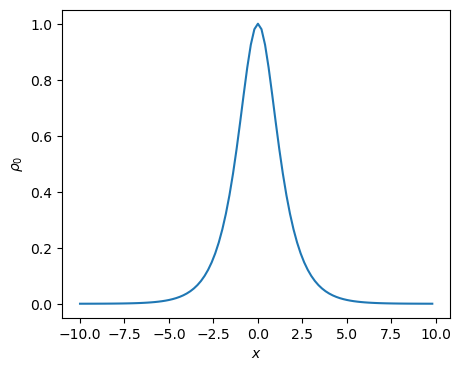

In [4]:
# Plotting

plt.figure(figsize=(5,4))

plt.plot(x, rho_0)

plt.xlabel(r"$x$")
plt.ylabel(r"$\rho_0$")

plt.show()

## Part 1 : FFT method

### Define the spatial frequencies ($k$):

In [5]:
# Wavenumbers - spatial frequencies:

k_numbers = 2*np.pi*np.fft.fftfreq(len(x), d=delta_x)

#print(k_numbers.shape)

#print(k_numbers)

### FFT of the initial profile:

In [6]:
# FFT of the initial condition

rho_0_hat = np.fft.fft(rho_0)

#print(rho_0_hat.shape)

In [7]:
# Norm of Fourier transform

ampli_rho_0_hat = np.abs(rho_0_hat)/(rho_0_hat.size//2)

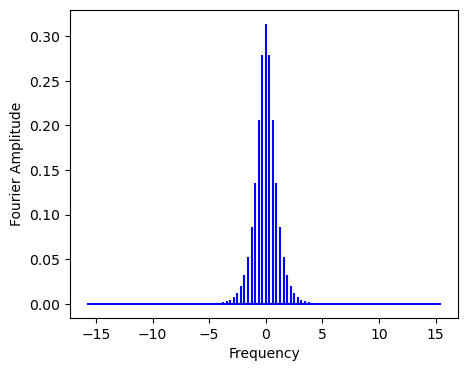

In [8]:
# Plotting

plt.figure(figsize = (5, 4))
plt.stem(k_numbers, ampli_rho_0_hat, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency')
plt.ylabel('Fourier Amplitude')

plt.show()

### Concatenate real and complex arrays

ODE integrators don't like complex numbers.

In [9]:
rho_0_conc = np.concatenate((rho_0_hat.real, rho_0_hat.imag))
#print(rho_0_hat.shape, rho_0_conc.shape)

In [10]:
#print(rho_0_conc)

### Time discretisation:

In [11]:
# Time step
t_step = 0.025

# Nnumber of the step in the simulation
m = 100

# Create a time vector
t = np.arange(0, m*t_step, t_step)

print(t.shape)

(100,)


### IMPORTANT: Construct ODE (RHS of ODE)

In [12]:
# Function to get RHS

def rhs_ode(rho_0_conc, t, k_numbers, c):
    
    # Needed for the scipy integrator
    u_tilde = rho_0_conc[:n] + (1j)*rho_0_conc[n:]
    
    # RHS of the equation in Fourier space
    rhs_u_tilde = +(1j)*(c)*(k_numbers)*u_tilde
    
    # Return real numbers
    rhs_ode = np.concatenate((rhs_u_tilde.real, rhs_u_tilde.imag))
    
    return rhs_ode

### k ODEs: solution

In [13]:
import scipy.integrate as sint

In [14]:
# Call ODE integrator

fourier_sln = sint.odeint(rhs_ode, rho_0_conc, t, args = (k_numbers, c))

print(fourier_sln.shape)

(100, 200)


### Reconstruct Complex solution:

In [15]:
rho_fourier = fourier_sln[:, :n] + (1j)*fourier_sln[:, n:]

print(rho_fourier.shape)

(100, 100)


### Inverse Fourier transform of each rho_fourier

In [16]:
# For loop with k as index

inv_rho_solution = np.zeros(rho_fourier.shape, dtype = complex)

# Loop to fill up the real sln array
for k in range(len(t)):
    
    inv_rho_solution[k, :] = np.fft.ifft(rho_fourier[k, :])
    
#print(inv_rho_solution)

### Plotting the solution:

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


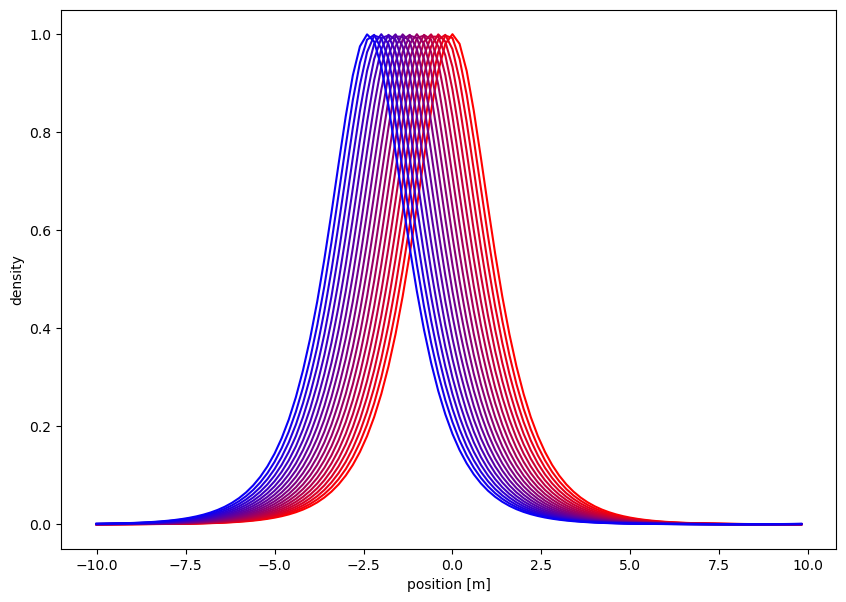

In [17]:
# Add colour

R = np.linspace(1, 0, m)
G = 0
B = np.linspace(0, 1, m)

# Figure environment
plt.figure(figsize= (10, 7))

for j in range(0, m, 5):
    plt.plot(x, inv_rho_solution[j, :], color = [R[j], G, B[j]])

plt.xlabel("position [m]")
plt.ylabel("density")

plt.show()

### Surface plot:

In [18]:
from mpl_toolkits.mplot3d import axes3d

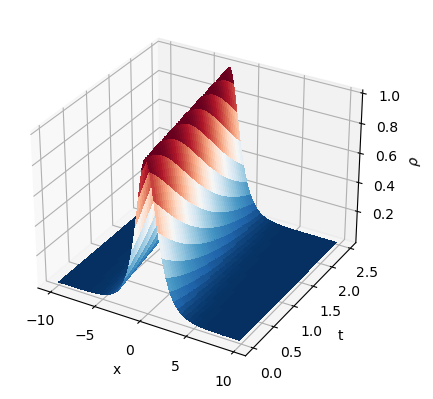

In [19]:
# Grid
x_grid, t_grid = np.meshgrid(x, t)

# Plot

fig = plt.figure()

ax = plt.axes(projection='3d')
#ax.contour3D(x_grid, t_grid, u, 1000, cmap='viridis') # Creates 'n=10' contours at different Z to make the surface

ax.plot_surface(x_grid, t_grid, inv_rho_solution.real, cmap='RdBu_r', linewidth=0, antialiased=False)

ax.set_xlabel('x')  # Customised labels for axes
ax.set_ylabel('t')
ax.set_zlabel(r'$\rho$')

plt.show()

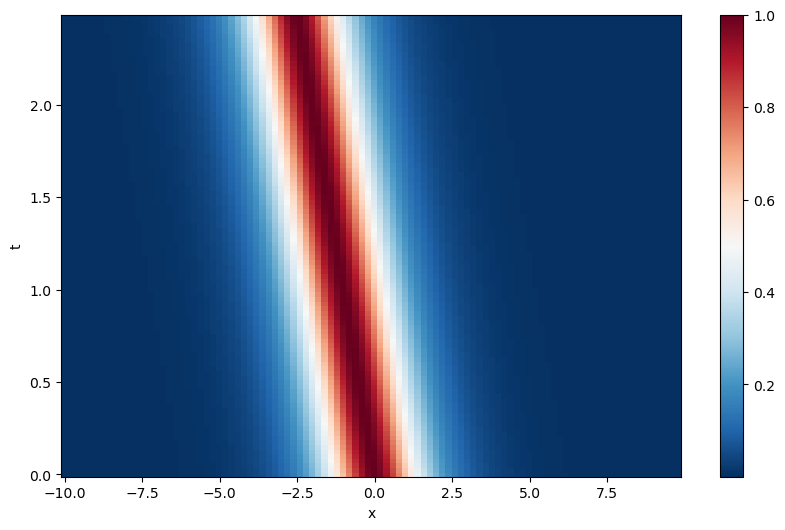

In [20]:
plt.figure(figsize= (10, 6))

#ax = plt.axes(projection='3d')
#ax.contour3D(x_grid, t_grid, u, 1000, cmap='viridis') # Creates 'n=10' contours at different Z to make the surface

Z = plt.pcolor(x_grid, t_grid, inv_rho_solution.real, cmap='RdBu_r')

plt.colorbar(Z)

plt.xlabel('x')
plt.ylabel('t')
#plt.zlabel('T')

plt.show()

In [21]:
# Add colour

for j in range(m):
    
    
    plt.figure(figsize= (10, 6))
    
    plt.plot(x, inv_rho_solution[j, :], color = "magenta")

    plt.xlabel("position [m]")
    plt.ylabel("density")

    plt.savefig("./wave1D{:03d}.png".format(j))
    
    plt.close()

In [22]:
import glob
from PIL import Image

In [23]:
images_in = "./wave****.png"

gif_image_out = "./animation_wave.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))

img = next(imgs)

img.save(fp = gif_image_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

## Part 2 : FFT method

### Simulation in Real spatial (x) domain

In [24]:
# Function to get RHS

def rhs_ode_spatial(rho_0, t, k_numbers, c):
    
    # Initial condition to Fourier space
    rho_hat_0 = np.fft.fft(rho_0)
    
    # Factor in front of u_hat in Fourier space
    rhs_u_tilde = -(1j)*(k_numbers)*rho_hat_0
    
    # Inverse FFT of the RHS
    rhs_u = np.fft.ifft(rhs_u_tilde).real
    
    # Back in Real Space
    rhs_ode = -c*rhs_u
    
    return rhs_ode

In [25]:
u_sln = rhs_ode_spatial(rho_0, t, k_numbers, c)

#print(u_sln)

### ODE Integration in real space:

In [26]:
# Call ODE integrator

solution_spatial = sint.odeint(rhs_ode_spatial, rho_0, t, args = (k_numbers, c))

print(solution_spatial.shape)

(100, 100)


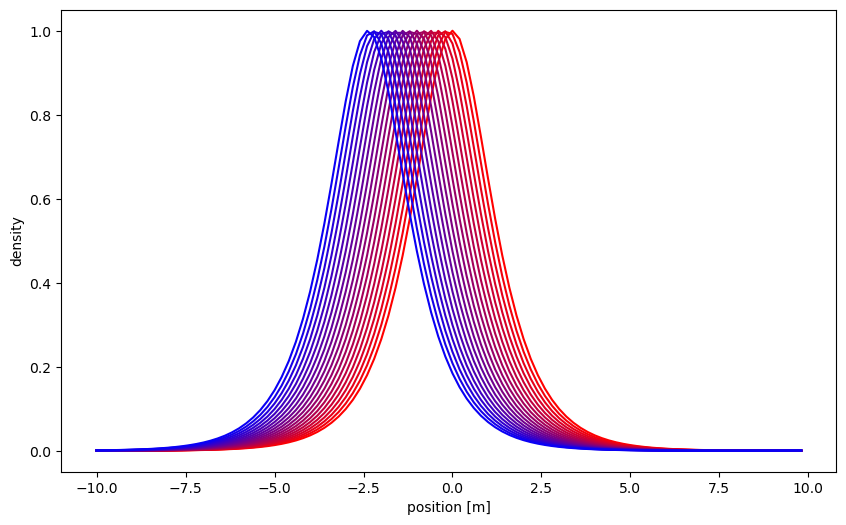

In [27]:
# Add colour

R = np.linspace(1, 0, m)
B = np.linspace(0, 1, m)
G = 0

plt.figure(figsize= (10, 6))

for j in range(0, m, 5):
    plt.plot(x, solution_spatial[j, :], color = [R[j], G, B[j]])

plt.xlabel("position [m]")
plt.ylabel("density")

plt.show()